#  Analyse spectra holo at AuxTel for Configurations


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022
- last update : October 1st 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

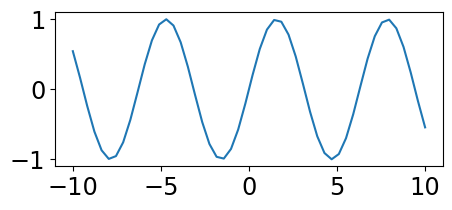

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-10-06'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220628"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DTRUNC.ini']
config_idx = 1
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF2D'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF2D'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Oct  6 15:45 2022062800078
drwxrws--- 1 dagoret lsst 2 Oct  6 15:52 2022062800134
drwxrws--- 1 dagoret lsst 2 Oct  6 16:45 2022062800135
drwxrws--- 1 dagoret lsst 2 Oct  6 15:54 2022062800136
drwxrws--- 1 dagoret lsst 2 Oct  6 20:03 2022062800137
drwxrws--- 1 dagoret lsst 2 Oct  6 15:20 2022062800161
drwxrws--- 1 dagoret lsst 2 Oct  6 15:21 2022062800162
drwxrws--- 1 dagoret lsst 2 Oct  6 15:29 2022062800163
drwxrws--- 1 dagoret lsst 2 Oct  6 15:25 2022062800164
drwxrws--- 1 dagoret lsst 2 Oct  6 15:16 2022062800188
drwxrws--- 1 dagoret lsst 2 Oct  6 15:17 2022062800189
drwxrws--- 1 dagoret lsst 2 Oct  6 15:20 2022062800190
drwxrws--- 1 dagoret lsst 2 Oct  6 15:20 2022062800215
drwxrws--- 1 dagoret lsst 2 Oct  6 15:23 2022062800218
drwxrws--- 1 dagoret lsst 2 Oct  6 15:51 2022062800242
drwxrws--- 1 dagoret lsst 2 Oct  6 15:17 2022062800243
drwxrws--- 1 dagoret lsst 2 Oct  6 15:35 2022062800244
drwxrws--- 1 dagoret lsst 2 Oct  6 15:24 2022062800245
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-06-29T00:32:58.582,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800078_postisrccd.fits,78,HD111980,empty_1,holo4_003,1.078823,30.0,...,9.6,12.0,4.8,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-06-29T01:23:07.878,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800134_postisrccd.fits,134,HD142331,empty_1,holo4_003,1.096328,30.0,...,9.9,13.0,3.8,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-06-29T01:23:50.778,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800135_postisrccd.fits,135,HD142331,empty_1,holo4_003,1.095673,30.0,...,9.9,13.0,2.9,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-06-29T01:24:33.789,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800136_postisrccd.fits,136,HD142331,empty_1,holo4_003,1.095025,30.0,...,9.9,13.0,5.3,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-06-29T01:25:16.788,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800137_postisrccd.fits,137,HD142331,empty_1,holo4_003,1.094388,30.0,...,10.0,13.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-06-29T01:41:43.686,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800161_postisrccd.fits,161,HD142331,empty_1,holo4_003,1.082667,30.0,...,10.0,13.0,4.3,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-06-29T01:42:26.587,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800162_postisrccd.fits,162,HD142331,empty_1,holo4_003,1.082277,30.0,...,9.9,13.0,3.9,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-06-29T01:43:09.670,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800163_postisrccd.fits,163,HD142331,empty_1,holo4_003,1.081893,30.0,...,9.9,13.0,3.6,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-06-29T01:43:52.677,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800164_postisrccd.fits,164,HD142331,empty_1,holo4_003,1.081521,30.0,...,9.9,13.0,3.6,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-06-29T02:00:20.342,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022062800188_postisrccd.fits,188,HD142331,empty_1,holo4_003,1.075756,30.0,...,10.2,13.0,3.8,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022062800078_postisrccd.fits
exposure_2022062800134_postisrccd.fits
exposure_2022062800135_postisrccd.fits
exposure_2022062800136_postisrccd.fits
exposure_2022062800137_postisrccd.fits
exposure_2022062800161_postisrccd.fits
exposure_2022062800162_postisrccd.fits
exposure_2022062800163_postisrccd.fits
exposure_2022062800164_postisrccd.fits
exposure_2022062800188_postisrccd.fits
exposure_2022062800189_postisrccd.fits
exposure_2022062800190_postisrccd.fits
exposure_2022062800191_postisrccd.fits
exposure_2022062800215_postisrccd.fits
exposure_2022062800216_postisrccd.fits
exposure_2022062800217_postisrccd.fits
exposure_2022062800218_postisrccd.fits
exposure_2022062800242_postisrccd.fits
exposure_2022062800243_postisrccd.fits
exposure_2022062800244_postisrccd.fits
exposure_2022062800245_postisrccd.fits
exposure_2022062800304_postisrccd.fits
exposure_2022062800305_postisrccd.fits
exposure_2022062800306_postisrccd.fits
exposure_2022062800307_postisrccd.fits
exposure_2022062800331_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022062800078', '2022062800134', '2022062800135', '2022062800136', '2022062800137', '2022062800161', '2022062800162', '2022062800163', '2022062800164', '2022062800188', '2022062800189', '2022062800190', '2022062800215', '2022062800218', '2022062800242', '2022062800243', '2022062800244', '2022062800245', '2022062800304', '2022062800305', '2022062800306', '2022062800307', '2022062800331', '2022062800333', '2022062800334', '2022062800358', '2022062800359', '2022062800360', '2022062800361', '2022062800389', '2022062800390', '2022062800391', '2022062800392', '2022062800416', '2022062800417', '2022062800418', '2022062800419', '2022062800443', '2022062800444', '2022062800445', '2022062800470', '2022062800471', '2022062800497', '2022062800498', '2022062800499', '2022062800531', '2022062800532', '2022062800556', '2022062800557', '2022062800583', '2022062800584', '2022062800617', '2022062800618', '2022062800619', '2022062800648', '2022062800649', '2022062800673', '2022062

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800136/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800137/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800161/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800162/basespec', '/sps/lsst/g

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec/exposure_2022062800078_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec/exposure_2022062800134_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec/exposure_2022062800135_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec/exposure_2022062800078_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec/exposure_2022062800134_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec/exposure_2022062800135_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec/exposure_2022062800078_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec/exposure_2022062800134_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec/exposure_2022062800135_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec/exposure_2022062800078_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec/exposure_2022062800134_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec/exposure_2022062800135_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

9 ) exposure_2022062800188_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800188/basespec/exposure_2022062800188_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.


2022-10-06 20:31:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.


set date_obs to 2022-06-29T02:00:50.576
set expo to 30.0
set airmass to 1.075702964907524
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.610374323672881
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.6985669314246
set parallactic_angle to -173.9187612418844


2022-10-06 20:31:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

============================ 0 ) exposure_2022062800078_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800078/basespec/exposure_2022062800078_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T00:33:28.824
set expo to 30.0
set airmass to 1.079226425722668
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -18.52222222222222
set hour_angle to 20.77733372226166
set temperature to 9.6
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 683.281332250176
set parallactic_angle to 125.7997741729093
target_name = HD111980, Selected object name for Simbad : HD111980


2022-10-06 20:31:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ... 0.0005170                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022062800134_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800134/basespec/exposure_2022062800134_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:23:38.112
set expo to 30.0
set airmass to 1.096076422825506
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.93109270902333
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.709602964965

2022-10-06 20:31:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022062800135_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800135/basespec/exposure_2022062800135_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:24:21.008
set expo to 30.0
set airmass to 1.095425179644168
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.7522576213511
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.127513515

2022-10-06 20:31:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022062800136_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800136/basespec/exposure_2022062800136_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:25:04.020
set expo to 30.0
set airmass to 1.094781460374913
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.57258883279781
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.61525785

2022-10-06 20:31:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022062800137_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800137/basespec/exposure_2022062800137_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:25:47.018
set expo to 30.0
set airmass to 1.094147941289574
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.39291689909844
set temperature to 10.0
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 684.7452160

2022-10-06 20:31:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022062800161_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800161/basespec/exposure_2022062800161_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:42:13.916
set expo to 30.0
set airmass to 1.082516698750416
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -7.273149616246172
set temperature to 10.0
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to

2022-10-06 20:31:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022062800162_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800162/basespec/exposure_2022062800162_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:42:56.822
set expo to 30.0
set airmass to 1.082129709438381
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -7.094313463617543
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 

2022-10-06 20:31:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022062800163_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800163/basespec/exposure_2022062800163_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:43:39.909
set expo to 30.0
set airmass to 1.081750689841894
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -6.913594223558327
set temperature to 9.9
set pressure to 745.85
set humidity to 13.0
set lambda_ref to 685.6455465

2022-10-06 20:31:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022062800164_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800164/basespec/exposure_2022062800164_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:44:22.917
set expo to 30.0
set airmass to 1.081382762308823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -6.733919864153538
set temperature to 9.9
set pressure to 745.85
set humidity to 13.0
set lambda_ref to 685.7172151

2022-10-06 20:31:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022062800188_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800188/basespec/exposure_2022062800188_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:00:50.576
set expo to 30.0
set airmass to 1.075702964907524
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.610374323672881
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.6985669

2022-10-06 20:31:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022062800189_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800189/basespec/exposure_2022062800189_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:01:33.522
set expo to 30.0
set airmass to 1.075569873837859
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.430699769894574
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.682398

2022-10-06 20:31:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022062800190_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800190/basespec/exposure_2022062800190_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:02:16.522
set expo to 30.0
set airmass to 1.075446553592237
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.251023803052155
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.099636

2022-10-06 20:31:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022062800215_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800215/basespec/exposure_2022062800215_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:19:23.456
set expo to 30.0
set airmass to 1.075433313450609
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 2.038837330128327
set temperature to 10.4
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to

2022-10-06 20:31:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022062800218_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800218/basespec/exposure_2022062800218_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:21:32.446
set expo to 30.0
set airmass to 1.0758133081133
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 2.577231119980914
set temperature to 10.5
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 6

2022-10-06 20:32:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022062800242_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800242/basespec/exposure_2022062800242_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:37:59.470
set expo to 30.0
set airmass to 1.081691334066911
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 6.701394657967561
set temperature to 10.9
set pressure to 745.95
set humidity to 12.0
set lambda_ref to 684.812607

2022-10-06 20:32:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022062800243_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800243/basespec/exposure_2022062800243_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:38:42.421
set expo to 30.0
set airmass to 1.082061179864083
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 6.880231848098011
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 685.000014

2022-10-06 20:32:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022062800244_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800244/basespec/exposure_2022062800244_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:39:25.418
set expo to 30.0
set airmass to 1.082442939892668
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 7.059907339570247
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 686.245289

2022-10-06 20:32:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022062800245_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800245/basespec/exposure_2022062800245_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:40:08.418
set expo to 30.0
set airmass to 1.082834698572837
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 7.239790759191675
set temperature to 10.8
set pressure to 745.9000000000001
set humidity to 12.0
set lambda_ref to

2022-10-06 20:32:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022062800304_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800304/basespec/exposure_2022062800304_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:46:40.058
set expo to 30.0
set airmass to 1.878227189845771
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -46.03448720154945
set temperature to 10.9
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 688.96689

2022-10-06 20:32:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022062800305_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800305/basespec/exposure_2022062800305_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_1499/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:47:22.955
set expo to 30.0
set airmass to 1.87791974366172
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.85460662440556
set temperature to 10.9
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.8446434205969
set parallactic_angle to -46.95991238341252
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:32:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022062800306_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800306/basespec/exposure_2022062800306_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:48:05.955
set expo to 30.0
set airmass to 1.877614225564679
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.67577540811912
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.78230

2022-10-06 20:32:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022062800307_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800307/basespec/exposure_2022062800307_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:48:48.959
set expo to 30.0
set airmass to 1.877309028585632
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.49610451271073
set temperature to 10.7
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.88081

2022-10-06 20:32:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022062800331_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800331/basespec/exposure_2022062800331_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:05:53.398
set expo to 30.0
set airmass to 1.547937816652001
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -57.45876326639303
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 683.48040

2022-10-06 20:32:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022062800333_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800333/basespec/exposure_2022062800333_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:07:19.314
set expo to 30.0
set airmass to 1.538355597754725
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -57.10004977723452
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.51214

2022-10-06 20:32:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022062800334_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800334/basespec/exposure_2022062800334_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:08:02.211
set expo to 30.0
set airmass to 1.533610586011093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -56.92037497801925
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 680.77778

2022-10-06 20:32:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022062800358_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800358/basespec/exposure_2022062800358_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:24:27.626
set expo to 30.0
set airmass to 1.434812942481714
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.80315068380267
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 681.435917

2022-10-06 20:32:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022062800359_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800359/basespec/exposure_2022062800359_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:25:10.582
set expo to 30.0
set airmass to 1.4308956968743
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.62347469097131
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 312.5238640

2022-10-06 20:32:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022062800360_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800360/basespec/exposure_2022062800360_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:25:53.578
set expo to 30.0
set airmass to 1.427011306362008
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.44379703673511
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 680.815258

2022-10-06 20:32:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022062800361_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800361/basespec/exposure_2022062800361_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:26:36.484
set expo to 30.0
set airmass to 1.4231728626988
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.26474718266238
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 681.10347469

2022-10-06 20:32:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022062800389_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800389/basespec/exposure_2022062800389_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:56:02.143
set expo to 30.0
set airmass to 1.288080270707517
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.89243391560788
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 681.50442

2022-10-06 20:32:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022062800390_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800390/basespec/exposure_2022062800390_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:56:45.076
set expo to 30.0
set airmass to 1.285297293465547
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.71359600818581
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 691.35163

2022-10-06 20:32:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 31 ) exposure_2022062800391_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800391/basespec/exposure_2022062800391_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:57:28.068
set expo to 30.0
set airmass to 1.28252054792018
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.53371304714648
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.397886

2022-10-06 20:32:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 32 ) exposure_2022062800392_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800392/basespec/exposure_2022062800392_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:58:10.966
set expo to 30.0
set airmass to 1.279766149263208
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.35403776873991
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 715.45687

2022-10-06 20:32:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 33 ) exposure_2022062800416_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800416/basespec/exposure_2022062800416_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:14:34.601
set expo to 30.0
set airmass to 1.222075456856667
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -40.24388451843497
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.01161

2022-10-06 20:32:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 34 ) exposure_2022062800417_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800417/basespec/exposure_2022062800417_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:15:17.634
set expo to 30.0
set airmass to 1.21977207186874
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -40.06421060962052
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 681.3583591

2022-10-06 20:32:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 35 ) exposure_2022062800418_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800418/basespec/exposure_2022062800418_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:16:00.548
set expo to 30.0
set airmass to 1.217485893913559
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -39.88453490427055
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 681.705762

2022-10-06 20:32:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 36 ) exposure_2022062800419_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800419/basespec/exposure_2022062800419_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:16:43.558
set expo to 30.0
set airmass to 1.215215493107239
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -39.70486111510608
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.24243

2022-10-06 20:32:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 37 ) exposure_2022062800443_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800443/basespec/exposure_2022062800443_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:33:01.792
set expo to 30.0
set airmass to 1.167964694700243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.61783692930108
set temperature to 11.2
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 1082.21844

2022-10-06 20:32:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 38 ) exposure_2022062800444_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800444/basespec/exposure_2022062800444_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:33:44.887
set expo to 30.0
set airmass to 1.166058888816991
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.43732730421768
set temperature to 11.1
set pressure to 745.5999999999999
set humidity to 12.0
set lambda_ref t

2022-10-06 20:32:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 39 ) exposure_2022062800445_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800445/basespec/exposure_2022062800445_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:34:27.794
set expo to 30.0
set airmass to 1.164186239506475
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.25849046579231
set temperature to 11.1
set pressure to 745.5999999999999
set humidity to 12.0
set lambda_ref t

2022-10-06 20:32:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 40 ) exposure_2022062800470_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800470/basespec/exposure_2022062800470_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:51:34.087
set expo to 30.0
set airmass to 1.123354901484391
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -30.97014051865549
set temperature to 11.0
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 681.502170

2022-10-06 20:32:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 41 ) exposure_2022062800471_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800471/basespec/exposure_2022062800471_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:52:17.029
set expo to 30.0
set airmass to 1.121809678275105
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -30.7913011786234
set temperature to 11.0
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 681.626258

2022-10-06 20:32:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 42 ) exposure_2022062800497_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800497/basespec/exposure_2022062800497_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:10:02.532
set expo to 30.0
set airmass to 1.087229429076941
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -26.33948736997695
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 1069.2576

2022-10-06 20:32:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 43 ) exposure_2022062800498_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800498/basespec/exposure_2022062800498_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:10:45.500
set expo to 30.0
set airmass to 1.085979724972408
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -26.15981584079511
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 682.14506

2022-10-06 20:32:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 44 ) exposure_2022062800499_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800499/basespec/exposure_2022062800499_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:11:28.607
set expo to 30.0
set airmass to 1.084740858931738
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -25.98014536893655
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 681.52954

2022-10-06 20:32:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 45 ) exposure_2022062800531_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800531/basespec/exposure_2022062800531_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:34:35.609
set expo to 30.0
set airmass to 1.050291742420666
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -20.18717717291777
set temperature to 10.8
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 681.32593

2022-10-06 20:33:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 46 ) exposure_2022062800532_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800532/basespec/exposure_2022062800532_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:35:18.611
set expo to 30.0
set airmass to 1.049386737925106
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -20.00750307122265
set temperature to 10.8
set pressure to 745.4
set humidity to 12.0
set lambda_ref to 681.498031

2022-10-06 20:33:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 47 ) exposure_2022062800556_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800556/basespec/exposure_2022062800556_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:51:41.058
set expo to 30.0
set airmass to 1.031195970231679
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -15.90427293882822
set temperature to 10.8
set pressure to 745.25
set humidity to 12.0
set lambda_ref to 681.51823

2022-10-06 20:33:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 48 ) exposure_2022062800557_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800557/basespec/exposure_2022062800557_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:52:24.129
set expo to 30.0
set airmass to 1.030503052530464
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -15.72376505105374
set temperature to 10.8
set pressure to 745.25
set humidity to 12.0
set lambda_ref to 681.84244

2022-10-06 20:33:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 49 ) exposure_2022062800583_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800583/basespec/exposure_2022062800583_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:10:17.391
set expo to 30.0
set airmass to 1.01600066486825
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -11.24302394888529
set temperature to 10.6
set pressure to 745.0
set humidity to 12.0
set lambda_ref to 680.9753911

2022-10-06 20:33:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 50 ) exposure_2022062800584_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800584/basespec/exposure_2022062800584_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:11:00.315
set expo to 30.0
set airmass to 1.015525919204391
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -11.06334476079337
set temperature to 10.6
set pressure to 745.05
set humidity to 12.0
set lambda_ref to 681.52572

2022-10-06 20:33:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 51 ) exposure_2022062800617_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800617/basespec/exposure_2022062800617_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:36:41.804
set expo to 30.0
set airmass to 1.838218842844075
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 11.76649658062223
set temperature to 10.4
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 687.9032620

2022-10-06 20:33:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 52 ) exposure_2022062800618_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800618/basespec/exposure_2022062800618_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:37:24.804
set expo to 30.0
set airmass to 1.838304377261581
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 11.94637865179208
set temperature to 10.4
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 687.7310979

2022-10-06 20:33:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 53 ) exposure_2022062800619_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800619/basespec/exposure_2022062800619_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:38:07.769
set expo to 30.0
set airmass to 1.838390943694318
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 12.12605237696333
set temperature to 10.4
set pressure to 744.75
set humidity to 12.0
set lambda_ref to 687.809523

2022-10-06 20:33:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 54 ) exposure_2022062800648_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800648/basespec/exposure_2022062800648_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:19:17.810
set expo to 30.0
set airmass to 1.005673761687143
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 6.041428758227673
set temperature to 10.4
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 681.3590363

2022-10-06 20:33:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 55 ) exposure_2022062800649_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800649/basespec/exposure_2022062800649_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:20:00.770
set expo to 30.0
set airmass to 1.005932984229837
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 6.221105477420276
set temperature to 10.3
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 681.2465946

2022-10-06 20:33:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 56 ) exposure_2022062800673_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800673/basespec/exposure_2022062800673_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:36:28.324
set expo to 30.0
set airmass to 1.014059536947854
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.35694518521929
set temperature to 10.5
set pressure to 744.55
set humidity to 12.0
set lambda_ref to 681.433343

2022-10-06 20:33:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 57 ) exposure_2022062800674_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800674/basespec/exposure_2022062800674_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:37:11.233
set expo to 30.0
set airmass to 1.014505197957086
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.53578416952217
set temperature to 10.5
set pressure to 744.55
set humidity to 11.0
set lambda_ref to 1071.47290

2022-10-06 20:33:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 58 ) exposure_2022062800675_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800675/basespec/exposure_2022062800675_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:37:54.139
set expo to 30.0
set airmass to 1.014961219340105
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.71566982388564
set temperature to 10.6
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref to

2022-10-06 20:33:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 59 ) exposure_2022062800676_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800676/basespec/exposure_2022062800676_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:38:37.050
set expo to 30.0
set airmass to 1.015422843347028
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.8945061869251
set temperature to 10.6
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref to 

2022-10-06 20:33:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
=== ORIGINAL CALIB lines === 
============================ 60 ) exposure_2022062800700_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800700/basespec/exposure_2022062800700_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:14:16.779
set expo to 30.0
set airmass to 1.860502892494139
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 36.00321895455097
set temperature to 10.4
set pressure to 744.25
set humidity to 11.0
set lambda_ref to 688.140755

2022-10-06 20:33:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 61 ) exposure_2022062800701_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800701/basespec/exposure_2022062800701_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:14:59.810
set expo to 30.0
set airmass to 1.860756390068821
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 36.18373145533366
set temperature to 10.3
set pressure to 744.2
set humidity to 11.0
set lambda_ref to 688.3620975

2022-10-06 20:33:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 


## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T00:33:28.824
set expo to 30.0
set airmass to 1.079226425722668
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -18.52222222222222
set hour_angle to 20.77733372226166
set temperature to 9.6
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 683.281332250176
set parallactic_angle to 125.7997741729093
target_name = HD111980, Selected object name for Simbad : HD111980


2022-10-06 20:33:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:23:38.112
set expo to 30.0
set airmass to 1.096076422825506
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.93109270902333
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.709602964965
set parallactic_angle to -154.3516988055887
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:33:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:24:21.008
set expo to 30.0
set airmass to 1.095425179644168
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.7522576213511
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.1275135152802
set parallactic_angle to -154.678049568872
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:33:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:25:04.020
set expo to 30.0
set airmass to 1.094781460374913
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.57258883279781
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.6152578558585
set parallactic_angle to -155.0081414445056
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:33:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:25:47.018
set expo to 30.0
set airmass to 1.094147941289574
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.39291689909844
set temperature to 10.0
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 684.7452160117241
set parallactic_angle to -155.3404574348667
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:33:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:42:13.916
set expo to 30.0
set airmass to 1.082516698750416
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -7.273149616246172
set temperature to 10.0
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 685.7963429475988
set parallactic_angle to -163.5415674931006
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:42:56.822
set expo to 30.0
set airmass to 1.082129709438381
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -7.094313463617543
set temperature to 9.9
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 685.7187223155806
set parallactic_angle to -163.9210473740381
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:43:39.909
set expo to 30.0
set airmass to 1.081750689841894
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -6.913594223558327
set temperature to 9.9
set pressure to 745.85
set humidity to 13.0
set lambda_ref to 685.6455465776908
set parallactic_angle to -164.3063083663844
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:44:22.917
set expo to 30.0
set airmass to 1.081382762308823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -6.733919864153538
set temperature to 9.9
set pressure to 745.85
set humidity to 13.0
set lambda_ref to 685.7172151107065
set parallactic_angle to -164.6910908600855
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:00:50.576
set expo to 30.0
set airmass to 1.075702964907524
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.610374323672881
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.6985669314246
set parallactic_angle to -173.9187612418844
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:01:33.522
set expo to 30.0
set airmass to 1.075569873837859
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.430699769894574
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.6823987044256
set parallactic_angle to -174.3339862721662
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_74 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:02:16.522
set expo to 30.0
set airmass to 1.075446553592237
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.251023803052155
set temperature to 10.2
set pressure to 746.0
set humidity to 13.0
set lambda_ref to 685.0996365635598
set parallactic_angle to -174.7499259269559
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_75 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:19:23.456
set expo to 30.0
set airmass to 1.075433313450609
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 2.038837330128327
set temperature to 10.4
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 686.0230164811612
set parallactic_angle to 175.2419725981637
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_76 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:21:32.446
set expo to 30.0
set airmass to 1.0758133081133
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 2.577231119980914
set temperature to 10.5
set pressure to 745.9000000000001
set humidity to 13.0
set lambda_ref to 685.9730068863641
set parallactic_angle to 173.9952988662604
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_77 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:37:59.470
set expo to 30.0
set airmass to 1.081691334066911
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 6.701394657967561
set temperature to 10.9
set pressure to 745.95
set humidity to 12.0
set lambda_ref to 684.8126079088249
set parallactic_angle to 164.7609293924933
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_78 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:38:42.421
set expo to 30.0
set airmass to 1.082061179864083
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 6.880231848098011
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 685.0000147268893
set parallactic_angle to 164.3776247955434
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_79 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:39:25.418
set expo to 30.0
set airmass to 1.082442939892668
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 7.059907339570247
set temperature to 10.9
set pressure to 745.95
set humidity to 13.0
set lambda_ref to 686.245289512937
set parallactic_angle to 163.9942576566673
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_80 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T02:40:08.418
set expo to 30.0
set airmass to 1.082834698572837
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 7.239790759191675
set temperature to 10.8
set pressure to 745.9000000000001
set humidity to 12.0
set lambda_ref to 686.0233613917355
set parallactic_angle to 163.6122183697706
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:34:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_81 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:46:40.058
set expo to 30.0
set airmass to 1.878227189845771
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -46.03448720154945
set temperature to 10.9
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 688.9668960527722
set parallactic_angle to -47.14299362989924
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:34:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_82 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:47:22.955
set expo to 30.0
set airmass to 1.87791974366172
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.85460662440556
set temperature to 10.9
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.8446434205969
set parallactic_angle to -46.95991238341252
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:34:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_83 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:48:05.955
set expo to 30.0
set airmass to 1.877614225564679
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.67577540811912
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.7823006865907
set parallactic_angle to -46.77788694278174
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:34:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_84 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T03:48:48.959
set expo to 30.0
set airmass to 1.877309028585632
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -45.49610451271073
set temperature to 10.7
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 687.880815637635
set parallactic_angle to -46.59499457872456
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:34:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_85 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:05:53.398
set expo to 30.0
set airmass to 1.547937816652001
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -57.45876326639303
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 683.4804003529296
set parallactic_angle to -107.8406244128558
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_86 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:07:19.314
set expo to 30.0
set airmass to 1.538355597754725
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -57.10004977723452
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.5121404749119
set parallactic_angle to -107.7585213360037
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_87 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:08:02.211
set expo to 30.0
set airmass to 1.533610586011093
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -56.92037497801925
set temperature to 10.8
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 680.7777872473943
set parallactic_angle to -107.7175919190028
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_88 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:24:27.626
set expo to 30.0
set airmass to 1.434812942481714
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.80315068380267
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 681.4359174890521
set parallactic_angle to -106.8162648523177
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_89 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:25:10.582
set expo to 30.0
set airmass to 1.4308956968743
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.62347469097131
set temperature to 10.9
set pressure to 745.75
set humidity to 13.0
set lambda_ref to 312.523864023326
set parallactic_angle to -106.778571727646
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_90 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:25:53.578
set expo to 30.0
set airmass to 1.427011306362008
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.44379703673511
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 680.8152589589693
set parallactic_angle to -106.7410198394868
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_91 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:26:36.484
set expo to 30.0
set airmass to 1.4231728626988
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -52.26474718266238
set temperature to 10.9
set pressure to 745.7
set humidity to 13.0
set lambda_ref to 681.1034746970889
set parallactic_angle to -106.7037406000086
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:34:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_92 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:56:02.143
set expo to 30.0
set airmass to 1.288080270707517
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.89243391560788
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 681.5044295041928
set parallactic_angle to -105.3007746113052
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_93 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:56:45.076
set expo to 30.0
set airmass to 1.285297293465547
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.71359600818581
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 691.3516374480961
set parallactic_angle to -105.2702271434054
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_94 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 31, pagenum = 7/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:57:28.068
set expo to 30.0
set airmass to 1.28252054792018
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.53371304714648
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.397886195862
set parallactic_angle to -105.2396844247945
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_95 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 32, pagenum = 7/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T04:58:10.966
set expo to 30.0
set airmass to 1.279766149263208
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -44.35403776873991
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 715.4568786245668
set parallactic_angle to -105.2093618604357
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_96 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 33, pagenum = 7/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:14:34.601
set expo to 30.0
set airmass to 1.222075456856667
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -40.24388451843497
set temperature to 11.1
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.0116153503028
set parallactic_angle to -104.569834854823
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_97 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 34, pagenum = 7/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:15:17.634
set expo to 30.0
set airmass to 1.21977207186874
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -40.06421060962052
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 681.3583591637461
set parallactic_angle to -104.5444248589126
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_98 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 35, pagenum = 8/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:16:00.548
set expo to 30.0
set airmass to 1.217485893913559
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -39.88453490427055
set temperature to 11.1
set pressure to 745.8
set humidity to 12.0
set lambda_ref to 681.7057623532113
set parallactic_angle to -104.5192451065335
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_99 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 36, pagenum = 8/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:16:43.558
set expo to 30.0
set airmass to 1.215215493107239
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -39.70486111510608
set temperature to 11.0
set pressure to 745.75
set humidity to 12.0
set lambda_ref to 682.2424332574965
set parallactic_angle to -104.4942984566537
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_100 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 37, pagenum = 8/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:33:01.792
set expo to 30.0
set airmass to 1.167964694700243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.61783692930108
set temperature to 11.2
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 1082.218442997725
set parallactic_angle to -103.995672336453
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_101 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 38, pagenum = 8/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:33:44.887
set expo to 30.0
set airmass to 1.166058888816991
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.43732730421768
set temperature to 11.1
set pressure to 745.5999999999999
set humidity to 12.0
set lambda_ref to 1078.907562961396
set parallactic_angle to -103.9769902069494
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_102 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 39, pagenum = 8/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:34:27.794
set expo to 30.0
set airmass to 1.164186239506475
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -35.25849046579231
set temperature to 11.1
set pressure to 745.5999999999999
set humidity to 12.0
set lambda_ref to 682.5755287959574
set parallactic_angle to -103.9587883654827
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_103 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 40, pagenum = 9/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:51:34.087
set expo to 30.0
set airmass to 1.123354901484391
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -30.97014051865549
set temperature to 11.0
set pressure to 745.6
set humidity to 12.0
set lambda_ref to 681.502170751785
set parallactic_angle to -103.6253862589512
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_104 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 41, pagenum = 9/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T05:52:17.029
set expo to 30.0
set airmass to 1.121809678275105
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -30.7913011786234
set temperature to 11.0
set pressure to 745.65
set humidity to 12.0
set lambda_ref to 681.6262581887908
set parallactic_angle to -103.6163370943955
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_105 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 42, pagenum = 9/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:10:02.532
set expo to 30.0
set airmass to 1.087229429076941
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -26.33948736997695
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 1069.257642237877
set parallactic_angle to -103.5536334998401
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_106 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 43, pagenum = 9/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:10:45.500
set expo to 30.0
set airmass to 1.085979724972408
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -26.15981584079511
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 682.1450655170642
set parallactic_angle to -103.5587600064107
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_107 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 44, pagenum = 9/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:11:28.607
set expo to 30.0
set airmass to 1.084740858931738
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -25.98014536893655
set temperature to 10.8
set pressure to 745.45
set humidity to 13.0
set lambda_ref to 681.5295479552291
set parallactic_angle to -103.5645818255528
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_108 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 45, pagenum = 10/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:34:35.609
set expo to 30.0
set airmass to 1.050291742420666
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -20.18717717291777
set temperature to 10.8
set pressure to 745.35
set humidity to 12.0
set lambda_ref to 681.3259366709206
set parallactic_angle to -104.2300668928317
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_109 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 46, pagenum = 10/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:35:18.611
set expo to 30.0
set airmass to 1.049386737925106
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -20.00750307122265
set temperature to 10.8
set pressure to 745.4
set humidity to 12.0
set lambda_ref to 681.4980317144558
set parallactic_angle to -104.2697900234687
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_110 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 47, pagenum = 10/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:51:41.058
set expo to 30.0
set airmass to 1.031195970231679
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -15.90427293882822
set temperature to 10.8
set pressure to 745.25
set humidity to 12.0
set lambda_ref to 681.5182370767178
set parallactic_angle to -105.6741160374595
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_111 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 48, pagenum = 10/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T06:52:24.129
set expo to 30.0
set airmass to 1.030503052530464
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -15.72376505105374
set temperature to 10.8
set pressure to 745.25
set humidity to 12.0
set lambda_ref to 681.842440695969
set parallactic_angle to -105.7635859652251
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_112 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 49, pagenum = 10/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:10:17.391
set expo to 30.0
set airmass to 1.01600066486825
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -11.24302394888529
set temperature to 10.6
set pressure to 745.0
set humidity to 12.0
set lambda_ref to 680.9753911751764
set parallactic_angle to -109.2629524194274
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:35:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_113 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 50, pagenum = 11/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:11:00.315
set expo to 30.0
set airmass to 1.015525919204391
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to -11.06334476079337
set temperature to 10.6
set pressure to 745.05
set humidity to 12.0
set lambda_ref to 681.5257286379723
set parallactic_angle to -109.474734032737
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_114 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 51, pagenum = 11/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:36:41.804
set expo to 30.0
set airmass to 1.838218842844075
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 11.76649658062223
set temperature to 10.4
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 687.9032620714431
set parallactic_angle to 12.08643294346891
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:36:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_115 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 52, pagenum = 11/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:37:24.804
set expo to 30.0
set airmass to 1.838304377261581
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 11.94637865179208
set temperature to 10.4
set pressure to 744.8
set humidity to 12.0
set lambda_ref to 687.7310979827894
set parallactic_angle to 12.27112186463373
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:36:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_116 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 53, pagenum = 11/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T07:38:07.769
set expo to 30.0
set airmass to 1.838390943694318
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 12.12605237696333
set temperature to 10.4
set pressure to 744.75
set humidity to 12.0
set lambda_ref to 687.8095238029406
set parallactic_angle to 12.45559306515529
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:36:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_117 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 54, pagenum = 11/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:19:17.810
set expo to 30.0
set airmass to 1.005673761687143
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 6.041428758227673
set temperature to 10.4
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 681.3590363882236
set parallactic_angle to 120.4534157935856
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_118 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 55, pagenum = 12/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:20:00.770
set expo to 30.0
set airmass to 1.005932984229837
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 6.221105477420276
set temperature to 10.3
set pressure to 744.5
set humidity to 12.0
set lambda_ref to 681.2465946316186
set parallactic_angle to 119.7890300860154
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_119 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 56, pagenum = 12/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:36:28.324
set expo to 30.0
set airmass to 1.014059536947854
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.35694518521929
set temperature to 10.5
set pressure to 744.55
set humidity to 12.0
set lambda_ref to 681.4333435303297
set parallactic_angle to 110.3852675210274
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_120 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 57, pagenum = 12/13.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:37:11.233
set expo to 30.0
set airmass to 1.014505197957086
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.53578416952217
set temperature to 10.5
set pressure to 744.55
set humidity to 11.0
set lambda_ref to 1071.472906004328
set parallactic_angle to 110.1423093054183
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_121 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 58, pagenum = 12/13.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:37:54.139
set expo to 30.0
set airmass to 1.014961219340105
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.71566982388564
set temperature to 10.6
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref to 681.4953140856763
set parallactic_angle to 109.9066792614739
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_122 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 59, pagenum = 12/13.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T08:38:37.050
set expo to 30.0
set airmass to 1.015422843347028
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.30658333333333
set hour_angle to 10.8945061869251
set temperature to 10.6
set pressure to 744.5999999999999
set humidity to 11.0
set lambda_ref to 681.1194526680008
set parallactic_angle to 109.6807447255199
target_name = HD205905, Selected object name for Simbad : HD205905


2022-10-06 20:36:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_123 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ...  -0.0000570                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 60, pagenum = 13/13.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:14:16.779
set expo to 30.0
set airmass to 1.860502892494139
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 36.00321895455097
set temperature to 10.4
set pressure to 744.25
set humidity to 11.0
set lambda_ref to 688.1407552382932
set parallactic_angle to 36.91530826927945
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:36:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_124 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 61, pagenum = 13/13.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T09:14:59.810
set expo to 30.0
set airmass to 1.860756390068821
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to 36.18373145533366
set temperature to 10.3
set pressure to 744.2
set humidity to 11.0
set lambda_ref to 688.362097567305
set parallactic_angle to 37.09966042088793
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-06 20:36:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_125 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ...  -0.0000650                1


### Summary spectra

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

3 ) exposure_2022062800136_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2D/20220628/2022062800136/basespec/exposure_2022062800136_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T01:25:04.020
set expo to 30.0
set airmass to 1.094781460374913
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -11.57258883279781
set temperature to 9.9
set pressure to 745.8
set humidity to 13.0
set lambda_ref to 685.6152578558585
set parallactic_angle to -155.0081414445056
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-06 20:36:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_126 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                             
--------- ------------- ------------- ... ----------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ...  -0.0002360                1


In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD111980,2022-06-29T00:33:28.824,1.079226,9.6,745.80,12.0,0.000000
1,HD142331,2022-06-29T01:23:38.112,1.096076,9.9,745.80,13.0,0.835913
2,HD142331,2022-06-29T01:24:21.008,1.095425,9.9,745.80,13.0,0.847829
3,HD142331,2022-06-29T01:25:04.020,1.094781,9.9,745.80,13.0,0.859777
4,HD142331,2022-06-29T01:25:47.018,1.094148,10.0,745.80,13.0,0.871721
5,HD142331,2022-06-29T01:42:13.916,1.082517,10.0,745.90,13.0,1.145859
6,HD142331,2022-06-29T01:42:56.822,1.082130,9.9,745.90,13.0,1.157777
7,HD142331,2022-06-29T01:43:39.909,1.081751,9.9,745.85,13.0,1.169746
8,HD142331,2022-06-29T01:44:22.917,1.081383,9.9,745.85,13.0,1.181693


In [72]:
configmode

'PSF2D'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

Text(0.5, 1.0, 'airmassvs vs date')

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2304                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-06-29T09:14:59.810'                                             
MJD     =    59759.38541446766                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

# write in pickles files

In [82]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [83]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [84]:
pkl_infilename=pkl_outfilename

In [85]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [86]:
#content

In [87]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022062800078_postisrccd_spectrum.fits',
 {'number': 78.0,
  'object': 'HD111980',
  'dateobs': '2022-06-29T00:33:28.824',
  'refhour': 0.0,
  'airmass': 1.079226425722668,
  'pressure': 745.8,
  'temperature': 9.6,
  'humidity': 12.0,
  'targetx_pix': 306.8032109403203,
  'targety_pix': 1732.358619462691,
  'rotangle': -0.28,
  'd2ccd': 181.0202345569896,
  'all_lambdas': array([ 299.27965556,  299.63275034,  299.9858481 , ..., 1098.5480715 ,
         1098.88684546, 1099.22560998]),
  'all_fluxes': array([-2.07213895e-14, -1.99098199e-14, -1.98014141e-14, ...,
          3.42979885e-13,  3.66708770e-13,  3.80245083e-13]),
  'all_fluxes_err': array([2.69979374e-14, 2.29028806e-14, 1.78335650e-14, ...,
         7.37003145e-15, 9.64449965e-15, 1.15504621e-14]),
  'all_lambdas_order2': array([149.63982778, 149.81637517, 149.99292405, ..., 549.27403575,
         549.44342273, 549.61280499]),
  'all_fluxes_order2': array([0., 0., 0., ..., 0., 0., 0.]),
  'all_fluxes_err_order2': a